In [53]:

import pandas as pd
import numpy as np
np.random.seed(5151)
from keras.models import Sequential
from keras.layers import LSTM, TimeDistributed, GRU, Activation, Conv2D,AveragePooling2D,Flatten, TimeDistributed,concatenate, Input,BatchNormalization
from keras.layers import Dense
from keras.layers import Add
from keras.models import Model
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from matplotlib import pyplot as plt

In [54]:

url='https://raw.githubusercontent.com/NayantaraPrem/EthereumPricePrediction/master/final_dataset.csv'
df = pd.read_csv(url)
df.head(4)

,Date(UTC),UnixTimeStamp,BlockSize,AvgGasPrices,GasUsed,GasLimit,BlockTime,NetworkUtilization,TransactionFees,BlockDifficulty,...,to_tx_count_a413,toSum_a413,to_tx_count_6853,toSum_6853,to_tx_count_92ff,toSum_92ff,to_tx_count_fb32,toSum_fb32,to_tx_count_84f3,toSum_84f3
0,2015-07-30,1438214400,644,0.0,0,0,4.46,0.0,0.0,0.121,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-07-31,1438300800,582,0.0,0,0,12.58,0.0,0.0,0.603,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-08-01,1438387200,575,0.0,0,0,16.34,0.0,0.0,0.887,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-08-02,1438473600,581,0.0,0,0,16.12,0.0,0.0,1.020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
output_column = 'Price'
output_column_feature = 'Price'
X = df.drop(['Date(UTC)', 'UnixTimeStamp'], axis=1)

#drop rows with NaN values
X = X.fillna(0) 
features =['AddressCount','MarketCap']
from_cols = [col for col in X.columns if 'from' in col]
to_cols = [col for col in X.columns if 'to' in col]
print(len(to_cols))
print(len(from_cols))

X['Price']=X['Price'].diff()
X['AddressCount']=X['AddressCount'].diff()
X['MarketCap']=X['MarketCap'].diff()
X=X.dropna()



n_timesteps = 7
n_features = len(features)
n_outputs = 1 # no. of days to predict
N = len(X[523:])
print(features)

30
28
['AddressCount', 'MarketCap']


In [56]:
train_split = 0.8 #20% test, 80% train
X_train = X[0:round((N)*train_split)]
X_test = X[round(N*train_split):]
N_test = X_test.shape[0]
N_train = X_train.shape[0]
len(X_train)

826

In [57]:
#scale training data
# input = 3 features. Column 4 shifted is output
input_scaler = MinMaxScaler(feature_range = (0, 1))
X_train_scaled = pd.DataFrame(input_scaler.fit_transform(X_train), columns=X_train.columns)
output_scaler = MinMaxScaler(feature_range = (0, 1))
output_scaler.fit(np.array(X_train[output_column]).reshape((N_train,1))) # scaling the output column
X_train_scaled.head()


,BlockSize,AvgGasPrices,GasUsed,GasLimit,BlockTime,NetworkUtilization,TransactionFees,BlockDifficulty,NetworkHash,EtherSupply,...,to_tx_count_a413,toSum_a413,to_tx_count_6853,toSum_6853,to_tx_count_92ff,toSum_92ff,to_tx_count_fb32,toSum_fb32,to_tx_count_84f3,toSum_84f3
0,0.000318,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.212070,0.0,0.0,0.000094,0.000052,0.001184,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000272,0.0,0.0,0.0,0.199662,0.0,0.0,0.000138,0.000135,0.002390,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000545,0.0,0.0,0.0,0.213762,0.0,0.0,0.000173,0.000190,0.003586,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000545,0.0,0.0,0.0,0.198534,0.0,0.0,0.000203,0.000251,0.004803,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
#input for other features
X_train_windows = []
y_train_windows = []
x_cnn = np.zeros((n_timesteps,4,15))
for i in range(N_train - n_timesteps):
    for j in range(n_timesteps):
        for k in range(15):
                    x_cnn[j,0,k] = X_train_scaled.loc[i+j, to_cols[k*2]]
                    x_cnn[j,1,k] = X_train_scaled.loc[i+j, to_cols[k*2+1]]
                    if (k<2):
                        x_cnn[j,2,k] = X_train_scaled.loc[i+j, from_cols[k*2]]
                        x_cnn[j,3,k] = X_train_scaled.loc[i+j, from_cols[k*2+1]]
                    if (k==2):
                        x_cnn[j,2,k] = 0
                        x_cnn[j,3,k] = 0
                    if (k>2):
                        x_cnn[j,2,k] = X_train_scaled.loc[i+j, from_cols[(k-1)*2]]
                        x_cnn[j,3,k] = X_train_scaled.loc[i+j, from_cols[(k-1)*2+1]]

    X_train_windows.append(np.array(x_cnn))
    y_train_windows.append(np.array(X_train_scaled.loc[i+n_timesteps, X_train_scaled.columns == output_column]))

X_train_windows = np.array(X_train_windows)
X_train_windows=np.reshape(X_train_windows,(N_train - n_timesteps,n_timesteps,4,15,1))
y_train_windows = np.array(y_train_windows)
X_train_windows.shape, y_train_windows.shape


((819, 7, 4, 15, 1), (819, 1))

In [59]:
#input for CNNs
X_train_windows2 = []

for i in range(N_train - n_timesteps): 
    X_train_windows2.append(np.array(X_train_scaled.loc[i:i+n_timesteps-1, features]))
    
X_train_windows2 = np.array(X_train_windows2)
X_train_windows2.shape

(819, 7, 2)

In [60]:
#define the model

input1 = Input(shape = (n_timesteps,4,15,1))
model=(TimeDistributed(Conv2D(16, (1, 15),  activation="relu")))(input1)
model=(TimeDistributed(Conv2D(16, (4, 1), activation="relu")))(model)
model=(TimeDistributed(BatchNormalization(axis = -1)))(model)
model=(TimeDistributed(Flatten()))(model)


input2 =  Input(shape = (n_timesteps,len(features) ))

model_merge= concatenate([model, input2])

model_merge=LSTM(
    10,
    activation='relu',
    return_sequences=True)(model_merge)

model_merge=LSTM(10, activation='relu')(model_merge)
model_merge=(Activation('softmax'))(model_merge)
output=(Dense(1 ,activation='sigmoid'))(model_merge)

final_model = Model(inputs=[input1, input2], outputs=[output])


final_model.compile(optimizer='adam', loss='mse')


# train model
final_model.fit([X_train_windows, X_train_windows2], y_train_windows, epochs=200, verbose=0)

In [61]:
# test prediction

#scale the input to [0,1]
X_test_scaled = pd.DataFrame(input_scaler.fit_transform(X_test), columns=X_test.columns)

#input for CNN

X_test_windows = []
y_test_windows = []
x_cnn = np.zeros((n_timesteps,4,15))
for i in range(N_test - n_timesteps):
    for j in range(n_timesteps):
        for k in range(15):
            x_cnn[j,0,k] = X_test_scaled.loc[i+j, to_cols[k*2]]
            x_cnn[j,1,k] = X_test_scaled.loc[i+j, to_cols[k*2+1]]
            if (k<2):
                x_cnn[j,2,k] = X_test_scaled.loc[i+j, from_cols[k*2]]
                x_cnn[j,3,k] = X_test_scaled.loc[i+j, from_cols[k*2+1]]
            if (k==2):
                x_cnn[j,2,k] = 0
                x_cnn[j,3,k] = 0
            if (k>2):
                x_cnn[j,2,k] = X_test_scaled.loc[i+j, from_cols[(k-1)*2]]
                x_cnn[j,3,k] = X_test_scaled.loc[i+j, from_cols[(k-1)*2+1]]

    X_test_windows.append(np.array(x_cnn))
    y_test_windows.append(np.array(X_test_scaled.loc[i+n_timesteps, X_test_scaled.columns == output_column]))

X_test_windows = np.array(X_test_windows)
X_test_windows=np.reshape(X_test_windows,(N_test - n_timesteps,n_timesteps,4,15,1))

y_test_windows = np.array(y_test_windows)
X_test_windows.shape, y_test_windows.shape

((722, 7, 4, 15, 1), (722, 1))

In [62]:
#input for other features
X_test_windows2 = []

for i in range(N_test - n_timesteps): 
    X_test_windows2.append(np.array(X_train_scaled.loc[i:i+n_timesteps-1, features]))
    
X_test_windows2 = np.array(X_test_windows2)
X_test_windows2.shape

(722, 7, 2)

In [63]:
#run predictions on each window
y_pred = []


y_pred = final_model.predict([X_test_windows,X_test_windows2])


# rescale the predictions back to the original values
y_pred_scaled = output_scaler.inverse_transform(y_pred)
y_actual_scaled = output_scaler.inverse_transform(y_test_windows)

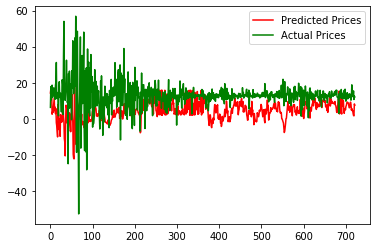

In [64]:
plt.plot(y_pred_scaled, color='red', label='Predicted Prices')
plt.plot(y_actual_scaled, color='green', label='Actual Prices')
plt.legend()
plt.show()

In [65]:
def make_df(y_pred,y_true):
    y_pred.name = 'y_pred'
    y_true.name = 'y_true'
    
    df = pd.concat([y_pred,y_true],axis=1)

    df['sign_pred'] = df.y_pred.apply(np.sign)
    df['sign_true'] = df.y_true.apply(np.sign)
    df['is_correct'] = 0
    df.loc[df.sign_pred * df.sign_true > 0 ,'is_correct'] = 1 # only registers 1 when prediction was made AND it was correct
    df['is_incorrect'] = 0
    df.loc[df.sign_pred * df.sign_true < 0,'is_incorrect'] = 1 # only registers 1 when prediction was made AND it was wrong
    df['is_predicted'] = df.is_correct + df.is_incorrect
    df['result'] = df.sign_pred * df.y_true 
    return df
def calc_scorecard(df):
    scorecard = pd.Series()
    # building block metrics
    scorecard.loc['accuracy'] = df.is_correct.sum()*1. / (df.is_predicted.sum()*1.)*100
    scorecard.loc['edge'] = df.result.mean()
    scorecard.loc['noise'] = df.y_pred.diff().abs().mean()

    # derived metrics
    scorecard.loc['y_true_chg'] = df.y_true.abs().mean()
    scorecard.loc['y_pred_chg'] = df.y_pred.abs().mean()
    scorecard.loc['prediction_calibration'] = scorecard.loc['y_pred_chg']/scorecard.loc['y_true_chg']
    scorecard.loc['capture_ratio'] = scorecard.loc['edge']/scorecard.loc['y_true_chg']*100

    # metrics for a subset of predictions
    scorecard.loc['edge_long'] = df[df.sign_pred == 1].result.mean()  - df.y_true.mean()
    scorecard.loc['edge_short'] = df[df.sign_pred == -1].result.mean()  - df.y_true.mean()

    scorecard.loc['edge_win'] = df[df.is_correct == 1].result.mean()  - df.y_true.mean()
    scorecard.loc['edge_lose'] = df[df.is_incorrect == 1].result.mean()  - df.y_true.mean()

    return scorecard
y_pred_scaled = y_pred_scaled.reshape(y_pred_scaled.shape[0])
y_actual_scaled = y_actual_scaled.reshape(y_actual_scaled.shape[0])
print(y_pred_scaled.shape)
df = make_df(pd.Series(y_pred_scaled-0.5),pd.Series(y_actual_scaled-0.5))

print(calc_scorecard(df))

(722,)
accuracy                  80.609418
edge                       7.750203
noise                      2.982450
y_true_chg                13.199035
y_pred_chg                 5.162403
prediction_calibration     0.391120
capture_ratio             58.717954
edge_long                  0.085210
edge_short               -24.285689
edge_win                   0.671144
edge_lose                -26.373345
dtype: float64
